In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from pylab import rcParams
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import pickle
import importlib
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
# Load the labeled index data from csv
labeled_index_dict = {}
labeled_index_dict['1m'] = pd.read_csv("./data/labeled_data/labeled_index_1m.csv")
labeled_index_dict['3m'] = pd.read_csv("./data/labeled_data/labeled_index_3m.csv")
labeled_index_dict['6m'] = pd.read_csv("./data/labeled_data/labeled_index_6m.csv")


## Build the model

In [3]:
model_dict = {}

In [4]:
for month, labeled_index in labeled_index_dict.items():
    # Set up datasets
    X = labeled_index[['price_change', 'volume_change', 'volatility']]
    y = labeled_index['crash_label']

    feature_names = list(X.columns)

    # Handle extreme value
    X[~np.isfinite(X)] = np.finfo(np.float64).max
    X = np.clip(X, -1e6, 1e6) 

    # Handle NaN
    imputer = SimpleImputer(strategy='mean')
    X = imputer.fit_transform(X)

    # Split the training and testing data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Oversample the minority class (1) using SMOTE
    oversampler = SMOTE(sampling_strategy=0.5, random_state=42)
    X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

    # Undersample the majority class (0) using RandomUnderSampler
    undersampler = RandomUnderSampler(sampling_strategy=1.0, random_state=42)
    X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_oversampled, y_train_oversampled)

    # Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_resampled)

    # Hyperparameter Tuning
    param_grid = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear', 'sag', 'saga']}
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, verbose=2)
    try:
        grid_search.fit(X_train_scaled, y_train_resampled)
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
        print(f"Best Score: {best_score}")
        print("Grid search completed successfully.")
    except Exception as e:
        print("Error occurred during grid search:")
        print(e)

    # Train the model
    model_dict[month] = LogisticRegression(C=best_params['C'], solver=best_params['solver'])
    model_dict[month].fit(X_train_scaled, y_train_resampled)
    print(month, " prediction model trained")
    print()

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ....................C=0.001, penalty=l1, solver=sag; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1

[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.6s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.6s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.6s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.5s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.5s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.5s
[CV] END ........................C=1, penalty=l2, solver=sag; total time=   0.5s
[CV] END ...................

[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.5s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.6s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.5s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.5s
Best Score: 0.5021789024376194
Grid search completed successfully.
Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear;

[CV] END ........................C=1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.6s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.6s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.6s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.6s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.6s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ..................C

[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.2s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.5s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.1s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.6s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.6s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.6s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.6s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.6s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.6s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.7s
[CV] END ....................C=1000, penalty=l2, solver=saga; total time=   0.7s
Best Score: 0.5019065809808225
Grid search completed successfully.
Fitting 5 folds for each of 42 candidates,

[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.3s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ........................C=1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ........................C=1, penalty=l1, solver=sag; total time=   0.0s
[CV] END .......................C=1, penalty=l1, solver=saga; total time=   0.5s
[CV] END ...................

[CV] END ....................C=1000, penalty=l1, solver=saga; total time=   0.6s
[CV] END ....................C=1000, penalty=l1, solver=saga; total time=   0.6s
[CV] END ....................C=1000, penalty=l1, solver=saga; total time=   0.6s
[CV] END ....................C=1000, penalty=l1, solver=saga; total time=   0.6s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END ...............C=1000, penalty=l2, solver=liblinear; total time=   0.1s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.5s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.5s
[CV] END .....................C=1000, penalty=l2, solver=sag; total time=   0.5s
[CV] END ...................

## Model Evaluation 
- Precision: number of True Positives / (number of True Positives + number of False Positives)
- Recall: number of True Positives / (number of True Positives + number of False Negatives)
- F1 score: A weighted average of precision and recall, F1 = 2*((precision*recall)/(precision+recall))

In [10]:
# Evaluate the model
for month, model in model_dict.items():
    print(month, "prediction model:")
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"Accuracy: {accuracy}")
    print(f"RMSE: {rmse}")
    print(f'MAPE: {mape}%') 

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print()
    print()

1m prediction model:
Accuracy: 0.9925303910559976
RMSE: 0.0864268994237462
MAPE: 100.0%
Confusion Matrix:
[[20330     0]
 [  153     0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     20330
         1.0       0.00      0.00      0.00       153

    accuracy                           0.99     20483
   macro avg       0.50      0.50      0.50     20483
weighted avg       0.99      0.99      0.99     20483



3m prediction model:
Accuracy: 0.9925303910559976
RMSE: 0.0864268994237462
MAPE: 100.0%
Confusion Matrix:
[[20330     0]
 [  153     0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     20330
         1.0       0.00      0.00      0.00       153

    accuracy                           0.99     20483
   macro avg       0.50      0.50      0.50     20483
weighted avg       0.99      0.99      0.99     20483



6m prediction model:

Problem: low recall and f1 score for crash label 1

## Feature Importance

1m prediction model:
Feature: price_change, Importance: -0.021364427394468435
Feature: volume_change, Importance: -0.023705875600677315
Feature: volatility, Importance: -0.02828754230819004


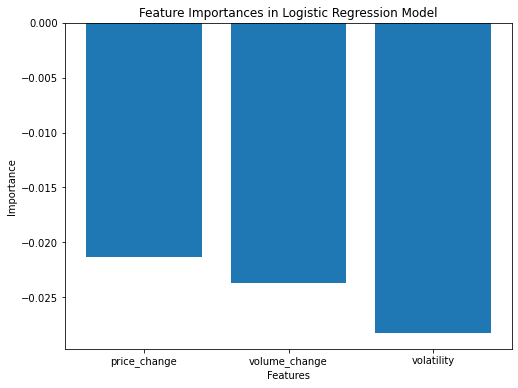

3m prediction model:
Feature: price_change, Importance: -0.026340382452741957
Feature: volume_change, Importance: -0.020586718139929027
Feature: volatility, Importance: -0.025194345937365963


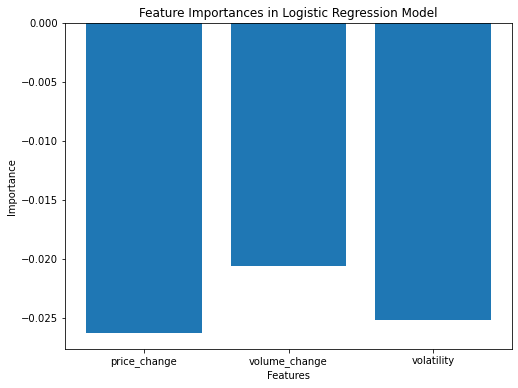

6m prediction model:
Feature: price_change, Importance: -0.8145378008865283
Feature: volume_change, Importance: -35.3044956242225
Feature: volatility, Importance: -0.04932259205392423


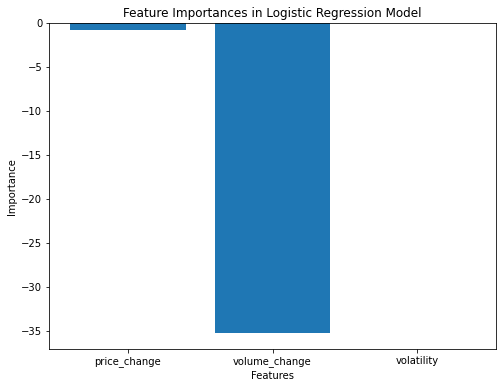

In [11]:
for month, model in model_dict.items():
    print(month, "prediction model:")
    feature_importance = model.coef_[0]
    for name, importance in zip(feature_names, feature_importance):
        print(f"Feature: {name}, Importance: {importance}")

    plt.figure(figsize=(8, 6))
    plt.bar(feature_names, feature_importance)
    plt.title('Feature Importances in Logistic Regression Model')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

## K-fold Validation

In [13]:
for month, model in model_dict.items():
    print(month, "prediction model:")

    # Perform 10-fold cross-validation
    scores = cross_val_score(model, X, y, cv=10)

    # Print the cross-validation scores
    print("Cross-validation scores: {}".format(scores))
    print("Average cross-validation score: {:.2f}".format(scores.mean()))
    print()

1m prediction model:
Cross-validation scores: [0.99248194 0.99248194 0.9923843  0.9924812  0.9924812  0.9924812
 0.9924812  0.9924812  0.9924812  0.9924812 ]
Average cross-validation score: 0.99

3m prediction model:
Cross-validation scores: [0.99248194 0.99248194 0.9923843  0.9924812  0.9924812  0.9924812
 0.9924812  0.9924812  0.9924812  0.9924812 ]
Average cross-validation score: 0.99

6m prediction model:
Cross-validation scores: [0.99248194 0.99248194 0.9923843  0.9924812  0.9924812  0.9924812
 0.9924812  0.9924812  0.9924812  0.9924812 ]
Average cross-validation score: 0.99



## Prediction Result & AUC-ROC

1m Crash Probability: 0.09300400206910607
1m AUC-ROC Score: 0.4590082269996046


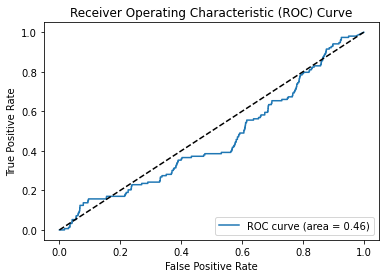

3m Crash Probability: 0.09772930522127828
3m AUC-ROC Score: 0.4590098344633804


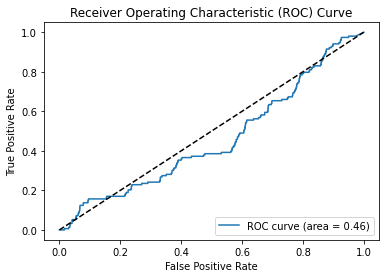

6m Crash Probability: 0.08214741652237714
6m AUC-ROC Score: 0.4557209635780858


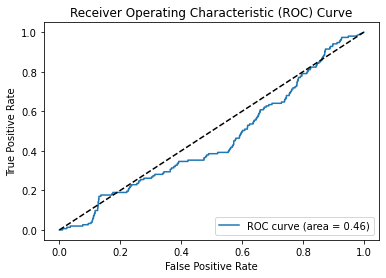

In [15]:
for month, model in model_dict.items():
    y_prob = model.predict_proba(X_test)
    crash_prob = y_prob[:, 1]
    print(f"{month} Crash Probability: {crash_prob.mean()}")
    auc_roc = roc_auc_score(y_test, y_prob[:, 1])

    print(f"{month} AUC-ROC Score: {auc_roc}")

    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, -1])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc_roc)
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()